# `Zarr` direct access example

**Author**: Nick Forbes-Smith, Denisse Fierro Arcos  
  
This notebook demonstrates how to access a public dataset from the RIMReP collection using `zarr`. We will use the [NOAA CRW degree heating weeks](https://www.coris.noaa.gov/search/catalog/search/resource/details.page?uuid=%7BF77EF0B8-C12F-463F-B66A-CC922E50A39D%7D) dataset as an example.  
  
We will also include examples of how to make simple calculations to produce maps and timeseries.

## Loading libraries

In [2]:
# Loading and manipulating gridded multidimensional data
import xarray as xr
# Accessing S3 buckets
import s3fs

## Connecting to S3 bucket and loading dataset

In [3]:
# Path to zarr files
zarr_path = "s3://gbr-dms-data-public/noaa-crw-chs-dhw/data.zarr"


# Connection to public S3 bucket - No credentials needed
s3 = s3fs.S3FileSystem(anon = True)

# Loading zarr file
data = xr.open_dataset(s3fs.S3Map(zarr_path, s3 = s3), engine = "zarr")

#Checking result
data

<xarray.Dataset> Size: 165GB
Dimensions:              (time: 14302, lat: 900, lon: 1600)
Coordinates:
  * lat                  (lat) float32 4kB -5.025 -5.075 ... -49.92 -49.97
  * lon                  (lon) float32 6kB 100.0 100.1 100.1 ... 179.9 180.0
  * time                 (time) datetime64[ns] 114kB 1985-03-25T12:00:00 ... ...
Data variables:
    crs                  int16 2B ...
    degree_heating_week  (time, lat, lon) float32 82GB ...
    mask                 (time, lat, lon) float32 82GB ...
Attributes: (12/59)
    Conventions:                CF-1.6, ACDD-1.3
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...
    acknowledgement:            NOAA Coral Reef Watch Program
    cdm_data_type:              Grid
    comment:                    This is a product of the NOAA Coral Reef Watc...
    contributor_name:           NOAA Coral Reef Watch Program
    ...                         ...
    time_coverage_duration:     P1D
    time_coverage_end:          20240521T000000Z
    time_coverage_resolution:   P1D
    time_coverage_start:        20240520T000000Z
    title:                      NOAA Coral Reef Watch Daily Global 5km Satell...
    uuid:                       24c7f597-298c-4be6-a0c2-ad97b993f60f

We can see that the above dataset has three dimensions: latitude (`lat`), longitude (`lon`) and time (`time`). This is a global dataset, with a spatial resolution of 5 km, and a daily temporal resolution between March 1985 and February 2023.  
  
We can see that there are two variables in the dataset: `degree heating week` (DHW) and `mask`. The `DHW` shows accumulated heat stress over a 12-week period, which can lead to coral bleaching and death. The scale ranges from $0^{\circ}C$ to $20^{\circ}C$-weeks. The `mask` includes the location of landmasses, grid cells covered by ice, and any grid cells with missing data.
  
We can get more information about each variable included in the dataset by calling their attributes as shown below.

In [4]:
data.mask.attrs

{'comment': 'A 2D array, in the same size as the data array in the X and Y directions, classifying land, missing, and ice pixels that are all flagged by the same missing_value (specified by the variable attribute _FillValue) in the data array(s), along with water (data) pixels.',
 'coverage_content_type': 'thematicClassification',
 'flag_meanings': 'valid-water land missing ice',
 'flag_values': [0, 1, 2, 4],
 'grid_mapping': 'crs',
 'long_name': 'pixel characteristics flag array',
 'units': 'pixel_classification'}

We can also check the metadata for the entire dataset by calling the dataset attributes as shown below.

In [5]:
data.attrs

{'Conventions': 'CF-1.6, ACDD-1.3',
 'NCO': 'netCDF Operators version 5.0.6 (Homepage = http://nco.sf.net, Code = http://github.com/nco/nco)',
 'acknowledgement': 'NOAA Coral Reef Watch Program',
 'cdm_data_type': 'Grid',
 'comment': 'This is a product of the NOAA Coral Reef Watch Daily Global 5km Satellite Coral Bleaching Heat Stress Monitoring Product Suite Version 3.1.',
 'contributor_name': 'NOAA Coral Reef Watch Program',
 'contributor_role': 'Collecting source data and deriving products; performing quality control of products; disseminating, storing, and submitting data to archive',
 'creator_email': 'coralreefwatch@noaa.gov',
 'creator_institution': 'NOAA/NESDIS/STAR Coral Reef Watch Program',
 'creator_name': 'NOAA Coral Reef Watch Program',
 'creator_type': 'group',
 'creator_url': 'https://coralreefwatch.noaa.gov/',
 'date_created': '20180301T120000Z',
 'date_issued': '20240521T141758Z',
 'date_metadata_modified': '20201118T120000Z',
 'date_modified': '20180301T120000Z',
 'ge

## Plotting data
Plotting data is easy with `xarray`, we can do it with a single line of code. Below, we will select the first time step of the `DHW` variable and plot a simple map using the `plot` method.

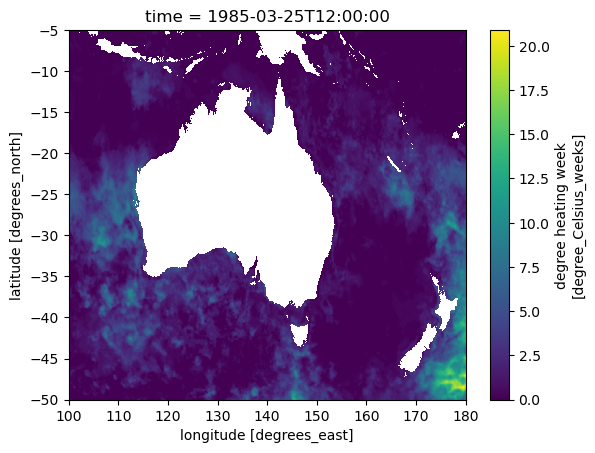

In [6]:
data.degree_heating_week.isel(time = 0).plot()

## Simple calculations using the entire grid
Below, we will create a new variable that will contain the `DHW` data for 2022. We will then calulate a monthly mean and finally we will plot the results.

In [7]:
# Subsetting data
dhw_2022 = data.degree_heating_week.sel(time = "2022")

# Checking result
dhw_2022

<xarray.DataArray 'degree_heating_week' (time: 365, lat: 900, lon: 1600)> Size: 2GB
[525600000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 4kB -5.025 -5.075 -5.125 ... -49.88 -49.92 -49.97
  * lon      (lon) float32 6kB 100.0 100.1 100.1 100.2 ... 179.9 179.9 180.0
  * time     (time) datetime64[ns] 3kB 2022-01-01T12:00:00 ... 2022-12-31T12:...
Attributes:
    coverage_content_type:  physicalMeasurement
    grid_mapping:           crs
    long_name:              degree heating week
    standard_name:          N/A
    units:                  degree_Celsius_weeks
    valid_max:              10000
    valid_min:              0

We can now group our 2022 data per calendar month and calculate the monthly mean.

In [8]:
# Calculating monthly means
dhw_monthly_2022 = dhw_2022.groupby("time.month").mean()

# Checking results
dhw_monthly_2022

<xarray.DataArray 'degree_heating_week' (month: 12, lat: 900, lon: 1600)> Size: 69MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 4kB -5.025 -5.075 -5.125 ... -49.88 -49.92 -49.97
  * lon      (lon) float32 6kB 100.0 100.1 100.1 100.2 ... 179.9 179.9 180.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    coverage_content_type:  physicalMeasurement
    grid_mapping:           crs
    long_name:              degree heating week
    standard_name:          N/A
    units:                  degree_Celsius_weeks
    valid_max:              10000
    valid_min:              0

Notice how the `time` dimension has been replaced by `month`, which includes 12 time step, one for each month of the year. We can now plot all monthly means for 2022. We use the `plot` method, specify `month` in the `col` argument, which will create a subplot for each month in our data. Finally, we use the `col_wrap` argument to specify the number of columns in our plot.

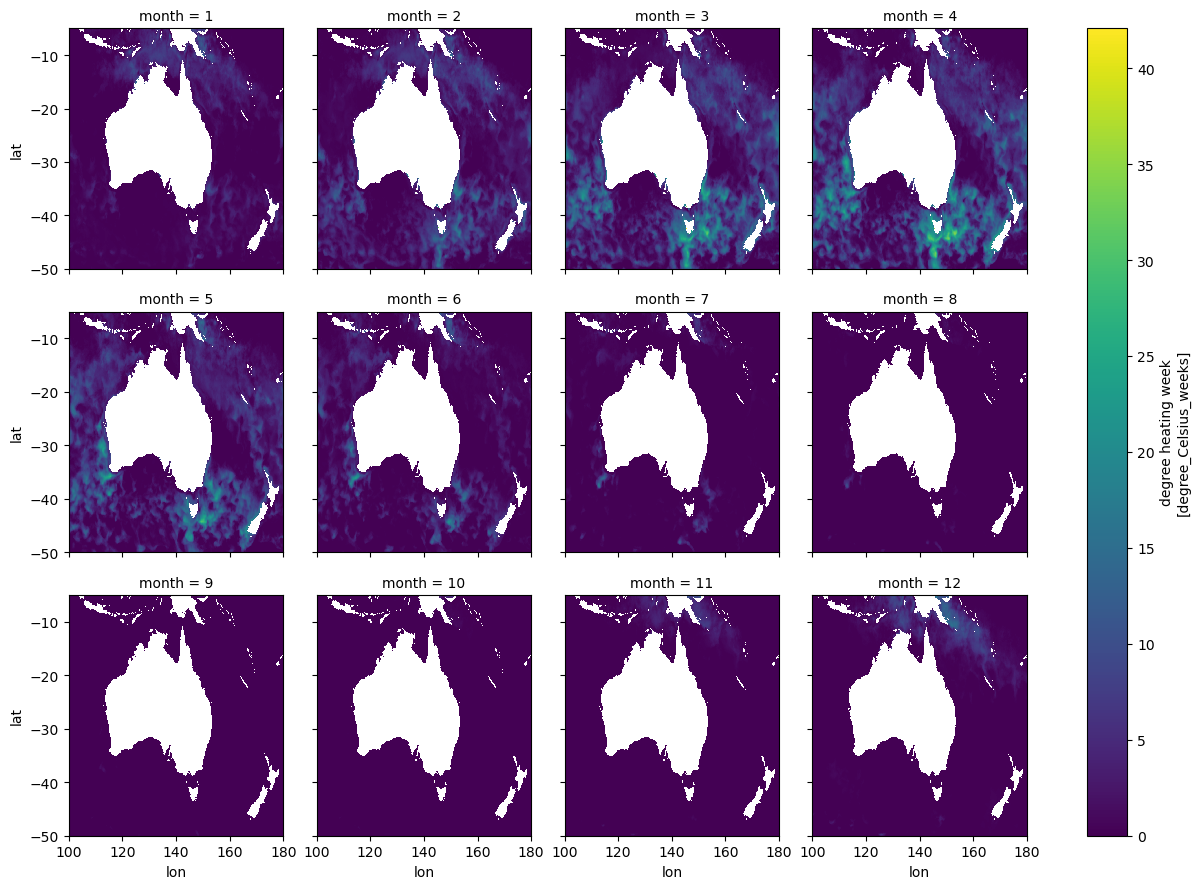

In [9]:
# Plotting monthly means
dhw_monthly_2022.plot(col = 'month', col_wrap = 4)

## Simple calculations at a single point over time
For this example, we will select a single point in the dataset and extract `DHW` values for all timesteps at that point to plot a time series. We will use the `sel` method to select the point nearest to `lat` = -20 and `lon` = 155. We will then subset the data temporally between 2020-01-01 and 2023-01-01, and plot it.  
  
We can do all this in a single line of code as shown below.

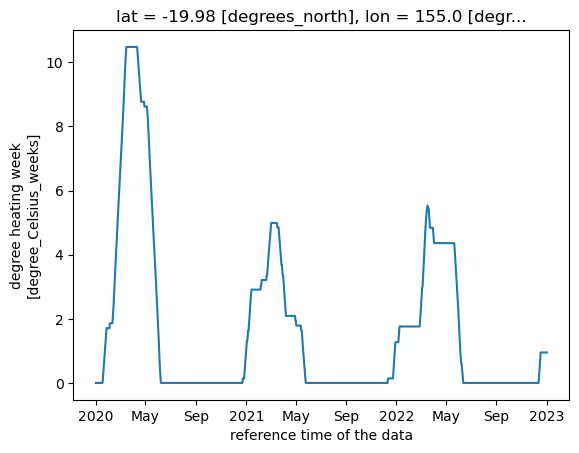

In [10]:
data.degree_heating_week.sel(lat = -20, lon = 155, method = 'nearest').\
    sel(time = slice('2020-01-01', '2023-01-01')).plot()

## Calculating time series over entire grid
We can also calculate time series for the entire grid. Below, we will show how to calculate the maximum `DHW` values for each pixel over 2022 summer months. We will then plot the results.

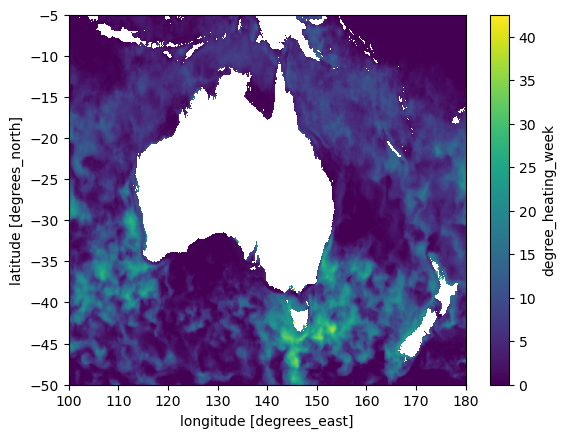

In [11]:
# Subsetting data for the period between 2020 and 2022
dhw_sub = data.degree_heating_week.sel(time = slice('2022-01-01', '2022-04-30'))

# Calculting mean at each time step and plot results
dhw_sub.max(dim='time').plot()